<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Classification/blob/main/Few_shot_classification_on_the_Omniglot_dataset_using_Reptile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few-shot classification on the Omniglot dataset using Reptile algorithm

**Author:**[Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 23/06/24
<br>
**Reference:**
- [On First-Order Meta-Learning Algorithms](https://doi.org/10.48550/arXiv.1803.02999)

- [Keras](https://keras.io/examples/vision/reptile/)

## Introduction to the Reptile Algorithm

- **Purpose**: Facilitates rapid adaptation to new tasks with minimal training data.
- **Meta-Learning Approach**: Model-agnostic meta-learning method.
- **Technique**: Uses Stochastic Gradient Descent (SGD) on a mini-batch of unseen data.
- **Iterations**: Conducts multiple meta-iterations.
- **Objective**: Adjusts model weights towards the updated mini-batch weights.
- **Outcome**: Enhances model's ability for few-shot learning and generalization.

## Imports

In [1]:
# Upgrade to keras 3
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.0 which is incompatible.


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import random

import keras
from keras import layers

## Define the Hyperparameters

In [3]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

## Prepare the data

1. **Dataset Overview**:
   - **Omniglot Dataset**: Contains 1,623 characters from 50 different alphabets.
   - **Character Examples**: Each character has 20 examples.
   - **Source of Data**: Samples were gathered using [Amazon's Mechanical Turk](https://github.com/brendenlake/omniglot).

2. **Few-Shot Learning Task**:
   - **Goal**: Train the model to learn new tasks with minimal examples (few-shot learning).
   - **Procedure**: Select \( k \) samples (or "shots") randomly from \( n \) randomly-chosen classes.
   - **Temporary Labels**: Assign temporary labels (0 to \( n-1 \)) to these classes for training the model on new tasks.

3. **Implementation Strategy**:
   - **Dataset Size**: Omniglot's diverse range of classes and sufficient samples per class make it suitable for few-shot learning experiments.
   - **Labeling**: When training on \( n \) classes, re-label the classes temporarily as 0 to \( n-1 \).
   - **Evaluation**: Test the model's ability to generalize to new classes by evaluating its performance on a separate set of classes not used during training.

4. **Dataset Preparation Steps**:
   - **Select Classes**: Randomly choose \( n \) classes from the 1,623 available.
   - **Sample Selection**: Randomly pick \( k \) examples (shots) from each of the \( n \) selected classes.
   - **Label Adjustment**: Assign temporary labels (0 to \( n-1 \)) to these \( k \times n \) examples.
   - **Split Data**: Divide the dataset into training and evaluation sets, ensuring classes in the evaluation set are disjoint from those in the training set to simulate a new task scenario effectively.

5. **Advantages of Omniglot Dataset**:
   - **Diversity**: Covers characters from a wide range of alphabets.
   - **Sample Size**: Provides a reasonable number of samples per character (20 examples).
   - **Suitability**: Ideal for few-shot learning experiments due to its varied classes and adequate sample size per class.


In [4]:
class Dataset:
  '''
  This will facilitate the creation of a few-shot dataset from
  the Omniglot dataset that can be sampled from quickly while also
  allowing to create new labels at the same time
  '''
  def __init__(self, training):
    # Download the tfrecord files containing the omniglot data and convert to dataset
    split = 'train' if training else 'test'
    ds = tfds.load('omniglot', split=split, as_supervised=True, shuffle_files=False)

    # Iterate over the dataset to get each individual image and its class and put that data into a dictionary
    self.data = {}

    def extraction(image, label):
      # This function will shrink the Omniglot images to the desired size, scale pixel values and convert to RGB image to grayscale
      image = tf.image.convert_image_dtype(image, tf.float32)
      image = tf.image.rgb_to_grayscale(image)
      image = tf.image.resize(image, [28, 28])
      return image, label

    for image, label in ds.map(extraction):
      image = image.numpy()
      label = str(label.numpy())
      if label not in self.data:
        self.data[label] = []
      self.data[label].append(image)
    self.labels = list(self.data.keys())

  def get_mini_dataset(
      self, batch_size, repetitions, shots, num_classes, split=False
  ):
      temp_labels = np.zeros(shape=(num_classes * shots))
      temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
      if split:
        test_labels = np.zeros(shape=(num_classes))
        test_images = np.zeros(shape=(num_classes, 28, 28, 1))

      # Get a random subset of labels from the entire label set
      label_subset = random.choices(self.labels, k=num_classes)
      for class_idx, class_obj in enumerate(label_subset):
        # Use enumerate index value as a temporary label fro mini-batch in few shot learning
        temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx

        # If creating a split dataset for testing, select an extra sample from label to create the test dataset
        if split:
          test_labels[class_idx] = class_idx
          images_to_split = random.choices(self.data[label_subset[class_idx]], k=shots + 1)
          test_images[class_idx] = images_to_split[-1]
          temp_images[class_idx * shots : (class_idx + 1) * shots] = images_to_split[:-1]

        else:
          # For each index in the randomly selected label_subset, sample the necessary number of images
          temp_images[class_idx * shots : (class_idx + 1) * shots] = random.choices(self.data[label_subset[class_idx]], k=shots)

      dataset = tf.data.Dataset.from_tensor_slices(
          (temp_images.astype(np.float32), temp_labels.astype(np.int32))
      )

      dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)

      if split:
        return dataset, test_images, test_labels
      return dataset

import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen download
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.QGRZP5_3.0.0/omniglot-train.tfrecord*...:   0%|       …

Generating test examples...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.QGRZP5_3.0.0/omniglot-test.tfrecord*...:   0%|        …

Generating small1 examples...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.QGRZP5_3.0.0/omniglot-small1.tfrecord*...:   0%|      …

Generating small2 examples...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.QGRZP5_3.0.0/omniglot-small2.tfrecord*...:   0%|      …

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


## Visualize some examples from the dataset

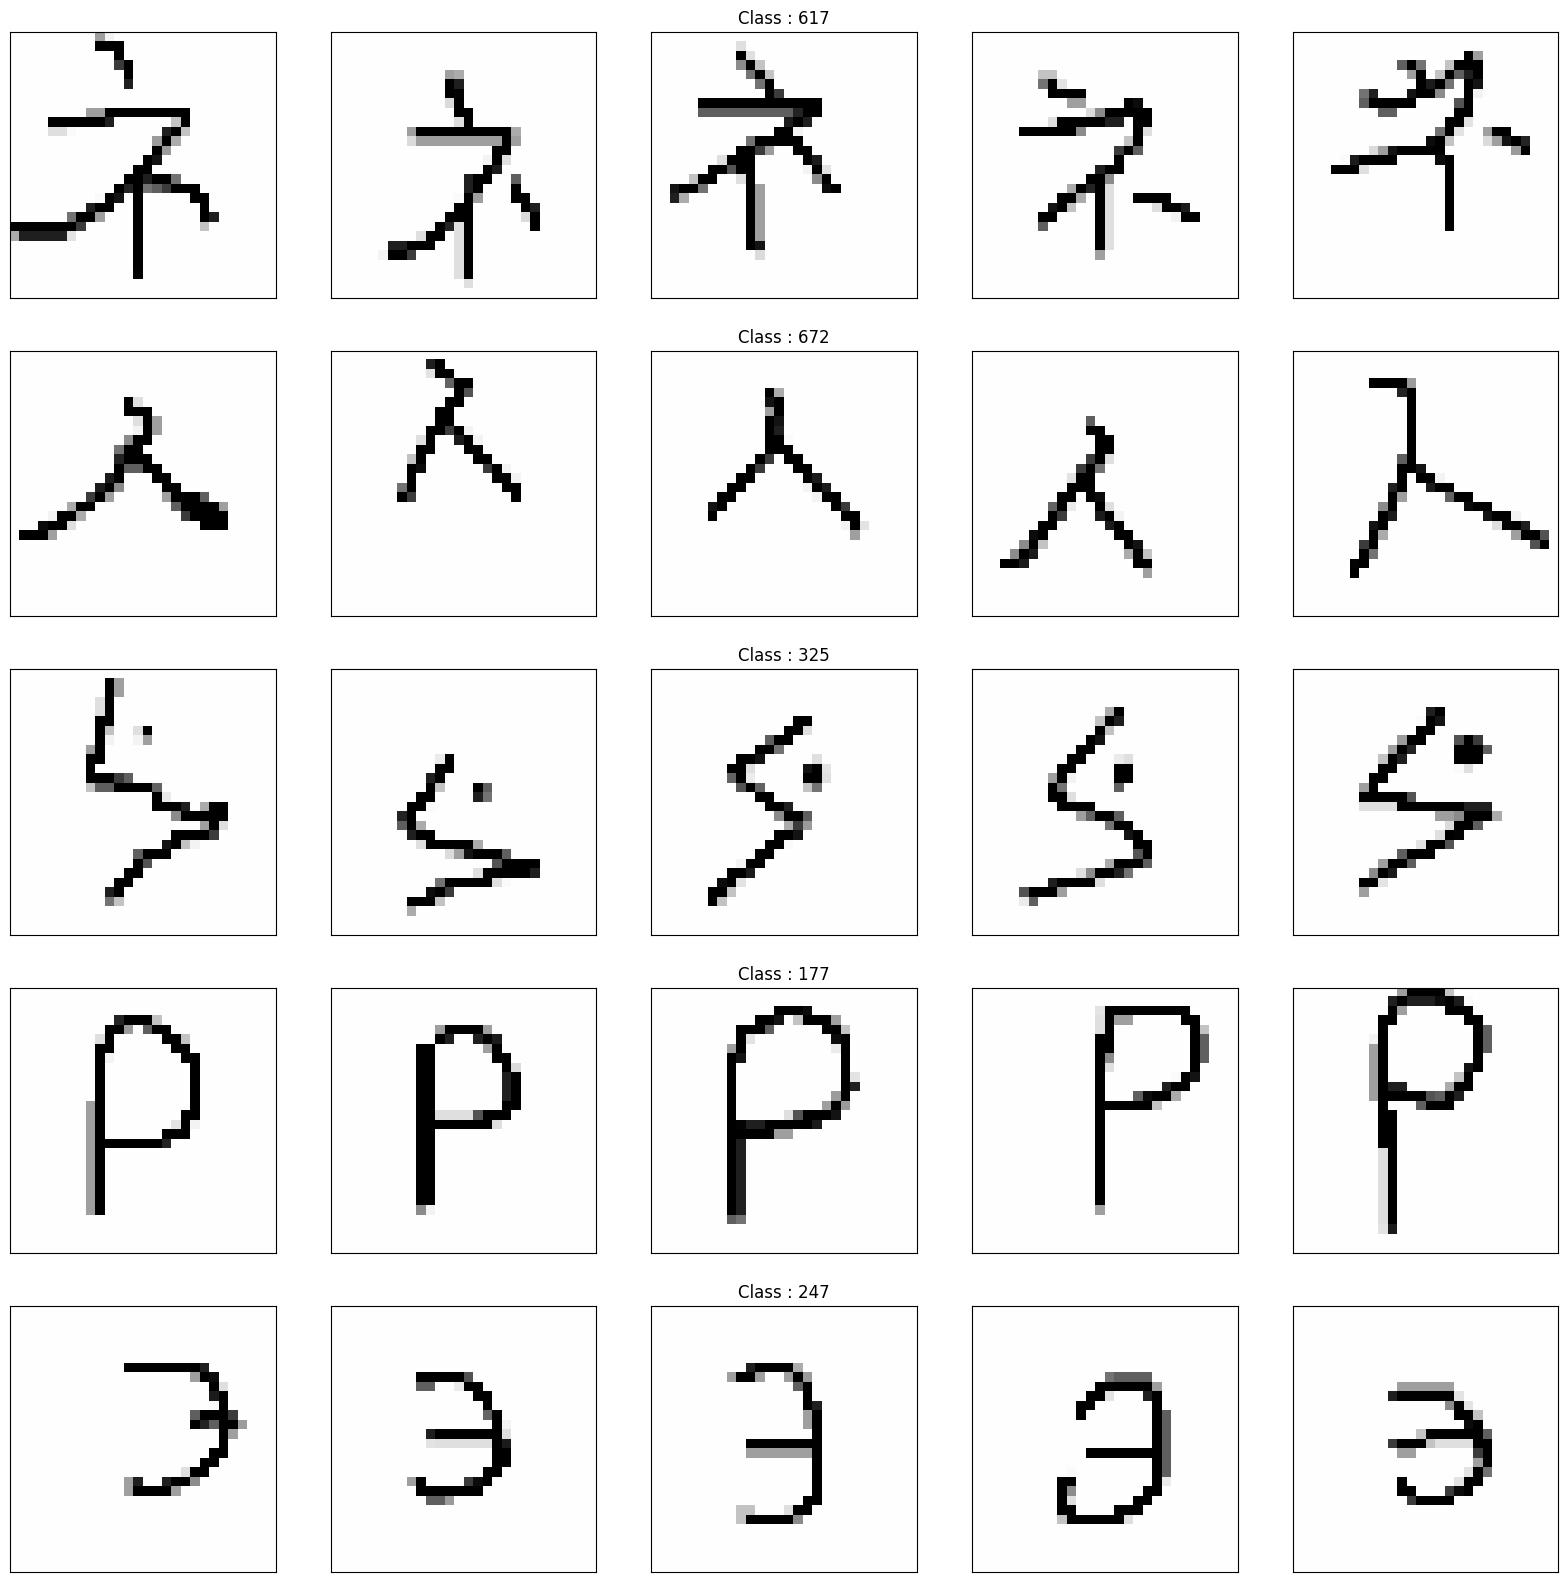

In [5]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
  for b in range(5):
    temp_image = train_dataset.data[sample_keys[a]][b]
    temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype('uint8')
    if b == 2:
      axarr[a, b].set_title('Class : ' + sample_keys[a])
    axarr[a, b].imshow(temp_image, cmap='gray')
    axarr[a, b].xaxis.set_visible(False)
    axarr[a, b].yaxis.set_visible(False)

plt.show()

## Build the model

In [6]:
def conv_bn(x):
  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  return layers.ReLU()(x)

inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)

outputs = layers.Dense(classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile()

optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

## Train the model

In [7]:
training = []
testing = []

for meta_iter in range(meta_iters):
  frac_done = meta_iter / meta_iters
  cur_meta_step_size = (1 - frac_done) * meta_step_size

  # Temporarily save the weights from the model
  old_vars = model.get_weights()

  # Get a sample from the full dataset
  mini_dataset = train_dataset.get_mini_dataset(
      inner_batch_size, inner_iters, train_shots, classes
  )

  for images, labels in mini_dataset:
    with tf.GradientTape() as tape:
      preds = model(images)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  new_vars = model.get_weights()

  # Perform SGD for the meta step
  for var in range(len(new_vars)):
    new_vars[var] = old_vars[var] + ((new_vars[var] - old_vars[var]) * cur_meta_step_size)

  # After the meta-learning step, reload the newly-trained weights into the model
  model.set_weights(new_vars)

  # Evaluate loop
  if meta_iter % eval_interval == 0:
    accuracies = []
    for dataset in (train_dataset, test_dataset):
      # Sample a mini dataset from the full dataset
      train_set, test_images, test_labels =dataset.get_mini_dataset(
          eval_batch_size, eval_iters, shots, classes, split=True
      )

      old_vars = model.get_weights()

      # Train on the samples and get the resulting accuracies
      for images, labels in train_set:
        with tf.GradientTape() as tape:
          preds = model(images)
          loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

      test_preds = model.predict(test_images)
      test_preds = tf.argmax(test_preds).numpy()
      num_correct = (test_preds == test_labels).sum()

      # Reset the weights after getting the evaluation accuracies
      model.set_weights(old_vars)
      accuracies.append(num_correct / classes)

    training.append(accuracies[0])
    testing.append(accuracies[1])

    if meta_iter % 100 == 0:
      print('batch %d: train=%f test=%f' % (meta_iter, accuracies[0], accuracies[1]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
batch 0: train=0.400000 test=0.800000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

## Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


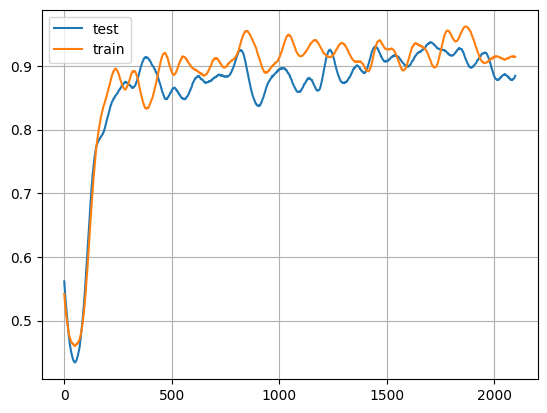

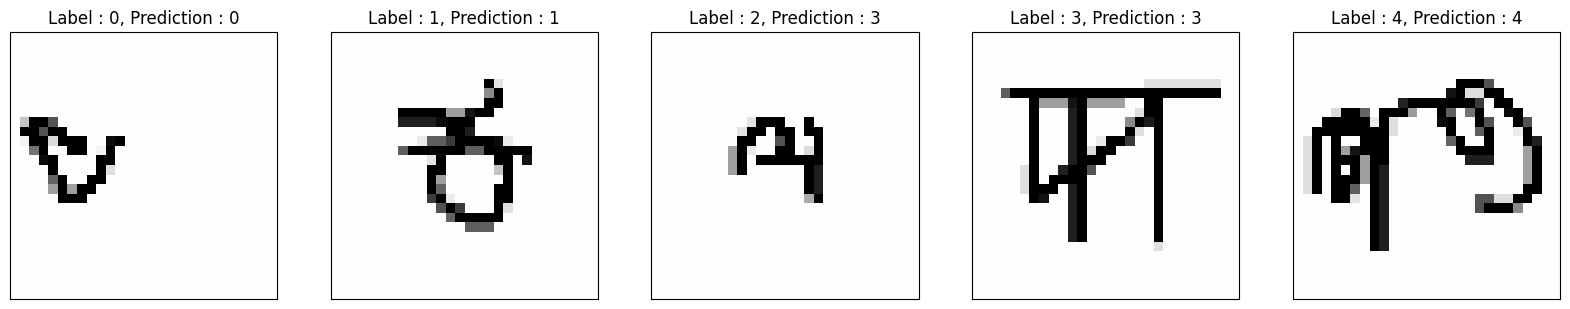

In [13]:
# Preprocessing to smooth training and testing arrays for display
window_length = 100

train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]

test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]

w = np.hamming(window_length)

train_y = np.convolve(w / w.sum(), train_s, mode='valid')
test_y = np.convolve(w / w.sum(), test_s, mode='valid')

# Display the training accuracies
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(['test', 'train'])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size,
    eval_iters,
    shots,
    classes,
    split=True,
)

for images, labels in train_set:
  with tf.GradientTape() as tape:
    preds = model(images)
    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype('uint8')
    ax.set_title(
        'Label : {}, Prediction : {}'.format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

plt.show()